In [60]:
### Regular Dropout

import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd

import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Use GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [61]:
from tueplots import bundles
plt.rcParams.update(bundles.beamer_moml())


# Also add despine to the bundle using rcParams
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

# Increase font size to match Beamer template
plt.rcParams['font.size'] = 16
# Make background transparent
plt.rcParams['figure.facecolor'] = 'none'

Inspired from: https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/DL2/Bayesian_Neural_Networks/dl2_bnn_tut2_student_with_answers.html

In [62]:
def get_simple_data_train():
    x = torch.linspace(-2, 4, 300)
    x = torch.hstack([x, torch.linspace(6, 8, 300)])
    f = lambda x: torch.sin(x)
    eps = torch.randn_like(x) * 0.1
    f_x = f(x) 
    y_train = f_x + eps
    x_train = x[:, None]
    return x_train, y_train, f

In [63]:
def plot_generic(add_to_plot=None):
    fig, ax = plt.subplots()

    plt.xlabel("X",)
    plt.ylabel("Y",)

    x_train, y_train, true_func = get_simple_data_train()
    
    x_all = torch.linspace(-2, 8, 1000)

    ax.plot(x_train, y_train, 'C0', marker='o', ms= 4, linestyle='none', alpha=0.2, label='Observations')
    ax.plot(x_all, true_func(x_all), 'C1', linewidth=1, label="true function")
    if add_to_plot is not None:
        add_to_plot(ax)

    plt.legend(loc=4, frameon=False)
    plt.show()

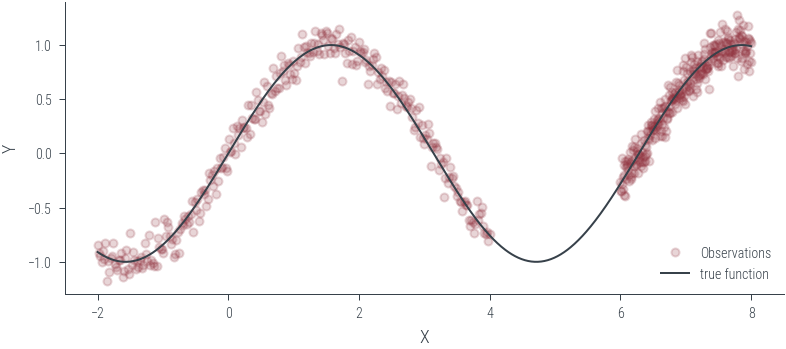

In [64]:
plot_generic()

In [75]:
# Define a simple MLP without using nn.Linear

input_dim = 1

hidden_l1_dim = 10
hidden_l2_dim = 5


def init_params():
    W1 = nn.Parameter(torch.randn(input_dim, hidden_l1_dim, requires_grad=True).to(device))
    b1 = nn.Parameter(torch.zeros(hidden_l1_dim, requires_grad=True).to(device))
    W2 = nn.Parameter(torch.randn(hidden_l1_dim, hidden_l2_dim, requires_grad=True).to(device))
    b2 = nn.Parameter(torch.zeros(hidden_l2_dim, requires_grad=True).to(device))
    W3 = nn.Parameter(torch.randn(hidden_l2_dim, 1, requires_grad=True).to(device))
    b3 = nn.Parameter(torch.zeros(1, requires_grad=True).to(device))
    return [W1, b1, W2, b2, W3, b3]


def mlp(x, params, p=0.0):
    W1, b1, W2, b2, W3, b3 = params
    h1 = torch.sin(x @ W1 + b1)
    h2 = torch.sin(h1 @ W2 + b2)
    return (h2 @ W3 + b3).ravel()

In [66]:
train_x, train_y, true_func = get_simple_data_train()
train_x = train_x.to(device)
train_y = train_y.to(device)


In [67]:
train_x.shape

torch.Size([600, 1])

In [68]:
test_x = torch.linspace(-2, 8, 1000)[:, None]
test_x = test_x.to(device)

In [76]:
parameters = init_params()


with torch.no_grad():
    y_hat_untrained = mlp(test_x, parameters).ravel()
# Detach and convert to numpy
y_hat_untrained = y_hat_untrained.cpu().detach().numpy()

In [77]:
def plot_predictions(x_test, y_preds):
    def add_predictions(ax):
        ax.plot(x_test, y_preds, 'C2', label='neural net prediction')

    plot_generic(add_predictions)


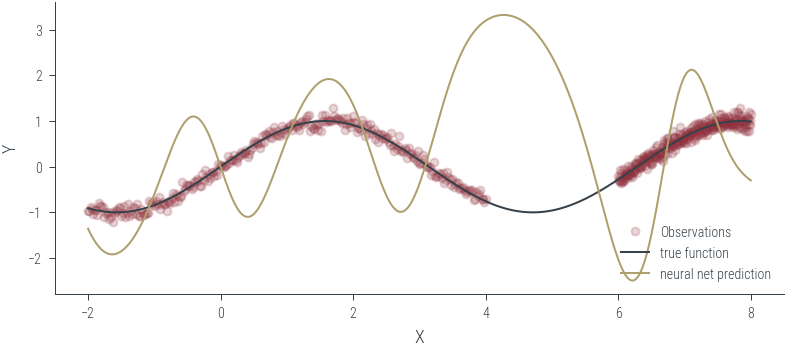

In [78]:
# Plot the untrained model
plot_predictions(test_x.cpu(), y_hat_untrained)

In [79]:
# Modify the train function to pass the dropout flag and dropout probability
def train(params, opt, fwd_func, x_train, y_train, epochs=1000, dropout=False, p=0.0):
    for i in range(epochs):
        y_hat = fwd_func(x_train, params, p)  # Pass the dropout flag and probability to fwd_func
        loss = F.mse_loss(y_hat, y_train)
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        if i % 200 == 0:
            print(f"Epoch {i}, loss {loss.item():.3f}")
    return params

In [80]:
parameters = init_params()

# Continue with optimizer
optimizer = torch.optim.Adam(parameters, lr=3e-4)

trained_params = train(parameters, optimizer, mlp, train_x, train_y, epochs=4000, dropout=False, p=0.0)

Epoch 0, loss 2.909
Epoch 200, loss 0.433
Epoch 400, loss 0.137
Epoch 600, loss 0.073
Epoch 800, loss 0.052
Epoch 1000, loss 0.041
Epoch 1200, loss 0.033
Epoch 1400, loss 0.028
Epoch 1600, loss 0.024
Epoch 1800, loss 0.021
Epoch 2000, loss 0.019
Epoch 2200, loss 0.018
Epoch 2400, loss 0.017
Epoch 2600, loss 0.016
Epoch 2800, loss 0.015
Epoch 3000, loss 0.014
Epoch 3200, loss 0.014
Epoch 3400, loss 0.013
Epoch 3600, loss 0.013
Epoch 3800, loss 0.012


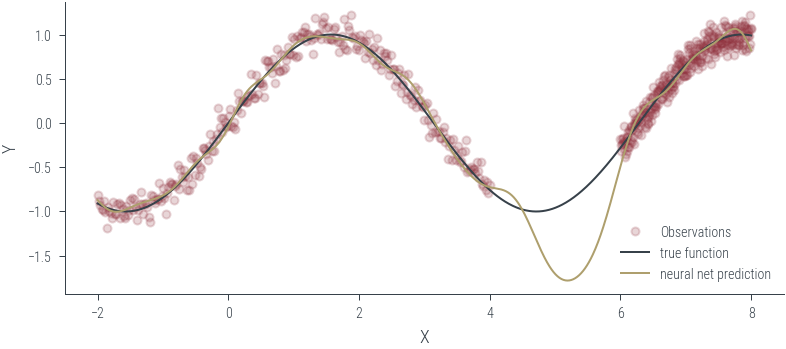

In [81]:
# Plot the trained model
with torch.no_grad():
    y_hat_trained = mlp(test_x, trained_params).ravel()
# Detach and convert to numpy
y_hat_trained = y_hat_trained.cpu().detach().numpy()

plot_predictions(test_x.cpu(), y_hat_trained)

In [82]:
### Now adding dropout to the model by manually masking the activations
W1, b1, W2, b2, W3, b3 = parameters
h1 = torch.relu(test_x @ W1 + b1)
h1.shape


torch.Size([1000, 10])

In [83]:
# probability of dropping out each neuron
p = 0.2

In [84]:
mask = torch.rand_like(h1) > p
mask.shape

torch.Size([1000, 10])

In [85]:
h1.shape

torch.Size([1000, 10])

In [86]:
mask.sum()

tensor(7962, device='cuda:0')

In [87]:
mask.numel()

10000

In [88]:
masked_activations = h1 * mask
masked_activations.shape

torch.Size([1000, 10])

In [89]:
pd.DataFrame(masked_activations.cpu().detach().numpy()).head()

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,2.918517,0.0,3.306101,0.0,3.068455,3.633291,0.0,0.0
1,0.0,0.0,2.904729,0.0,0.000000,0.0,3.053501,3.616080,0.0,0.0
2,0.0,0.0,2.890941,0.0,3.274221,0.0,3.038548,0.000000,0.0,0.0
3,0.0,0.0,2.877153,0.0,3.258281,0.0,0.000000,0.000000,0.0,0.0
4,0.0,0.0,2.863365,0.0,3.242341,0.0,3.008640,3.564445,0.0,0.0


In [90]:
pd.DataFrame(h1.cpu().detach().numpy()).head()

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,2.918517,0.0,3.306101,0.0,3.068455,3.633291,0.0,0.0
1,0.0,0.0,2.904729,0.0,3.290161,0.0,3.053501,3.616080,0.0,0.0
2,0.0,0.0,2.890941,0.0,3.274221,0.0,3.038548,3.598868,0.0,0.0
3,0.0,0.0,2.877153,0.0,3.258281,0.0,3.023594,3.581656,0.0,0.0
4,0.0,0.0,2.863365,0.0,3.242341,0.0,3.008640,3.564445,0.0,0.0


In [91]:
pd.DataFrame(mask.cpu().detach().numpy()).head()

,0,1,2,3,4,5,6,7,8,9
0,True,True,True,True,True,True,True,True,False,True
1,True,True,True,True,False,True,True,True,True,True
2,False,True,True,False,True,False,True,False,True,True
3,True,True,True,True,True,True,False,False,False,True
4,True,True,True,False,True,True,True,True,True,True


In [98]:
### Rewriting the model with dropout

def mlp_dropout(x, params, p=0.0, training=True):
    W1, b1, W2, b2, W3, b3 = params
    h1 = torch.sin(x @ W1 + b1)
    #h2 = torch.sin(h1 @ W2 + b2)
    #h3 = h2 @ W3 + b3
    #return h3
    if training:
        # probability of dropping out each neuron
        mask = torch.rand_like(h1) > p
        h1 = h1 * mask
        # scale activations to account for dropout
        #h1 = h1 / (1 - p)
    h2 = torch.sin(h1 @ W2 + b2)
    if training:
        # probability of dropping out each neuron
        mask = torch.rand_like(h2) > p
        h2 = h2 * mask
        # scale activations to account for dropout
        #h2 = h2 / (1 - p)
    h3 = h2 @ W3 + b3
    return h3.ravel()

In [99]:
# Train the model
p = 0.01
parameters = init_params()

# Continue with optimizer
optimizer = torch.optim.Adam(parameters, lr=3e-4)
trained_params = train(parameters, optimizer, mlp_dropout, train_x, train_y, epochs=4000, dropout=True, p=p)

Epoch 0, loss 5.334
Epoch 200, loss 0.889
Epoch 400, loss 0.529
Epoch 600, loss 0.457
Epoch 800, loss 0.401
Epoch 1000, loss 0.300
Epoch 1200, loss 0.286
Epoch 1400, loss 0.199
Epoch 1600, loss 0.188
Epoch 1800, loss 0.165
Epoch 2000, loss 0.196
Epoch 2200, loss 0.120
Epoch 2400, loss 0.139
Epoch 2600, loss 0.130
Epoch 2800, loss 0.094
Epoch 3000, loss 0.087
Epoch 3200, loss 0.083
Epoch 3400, loss 0.088
Epoch 3600, loss 0.077
Epoch 3800, loss 0.071


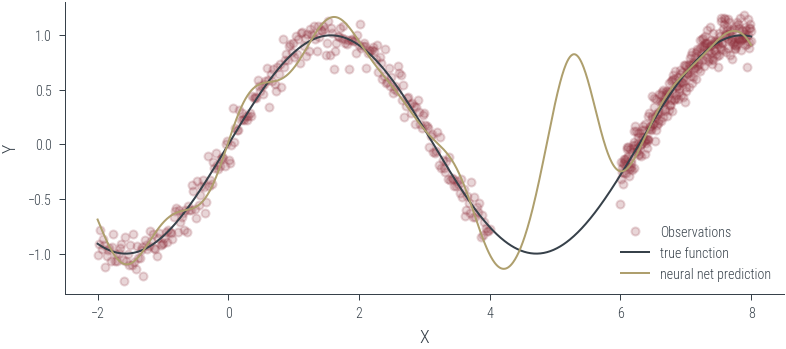

In [100]:
# Predictions with dropout
with torch.no_grad():
    y_hat_dropout = mlp_dropout(test_x, trained_params, training=False).ravel()

# Detach and convert to numpy
y_hat_dropout = y_hat_dropout.cpu().detach().numpy()

plot_predictions(test_x.cpu(), y_hat_dropout)

    

In [101]:
# Get the predictions for the test set with dropout set to True

preds = []
for i in range(100):
    with torch.no_grad():
        y_hat_dropout = mlp_dropout(test_x, trained_params, training=True, p=p).ravel()
    # Detach and convert to numpy
    y_hat_dropout = y_hat_dropout.cpu().detach().numpy()
    preds.append(y_hat_dropout)

In [102]:
# Plot MC dropout predictions

preds = np.array(preds)
preds.shape

(100, 1000)

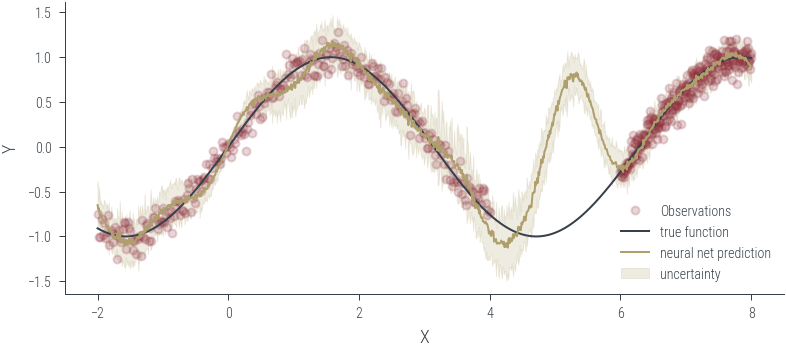

In [103]:
# Plot mean and variance of MC dropout predictions

mean = preds.mean(axis=0)
std = preds.std(axis=0)

def plot_predictions_with_uncertainty(x_test, y_preds, y_std):
    def add_predictions(ax):
        ax.plot(x_test, y_preds, 'C2', label='neural net prediction')
        ax.fill_between(x_test.ravel(), y_preds - y_std, y_preds + y_std, alpha=0.2, color='C2', label='uncertainty')

    plot_generic(add_predictions)

plot_predictions_with_uncertainty(test_x.cpu(), mean, std)
